In [3]:
#Set the random seed to ensure reproducible results
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# basic data processing library
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# data visualization library
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# set up Chinese font support
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# machine learning related libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve
)

# deep learning framework - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Embedding,
    Dropout,
    Bidirectional
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# text processing library
import re
from collections import Counter


import os
import time
from datetime import datetime

print(f"TensorFlow Version: {tf.__version__}")
print(f"Is GPU available: {tf.config.list_physical_devices('GPU')}")
print("All libraries imported successfully")

TensorFlow Version: 2.19.0
Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All libraries imported successfully


In [14]:
data_path = '/content/IMDB Dataset.csv'

start_time = time.time()

df = pd.read_csv(data_path)

load_time = time.time() - start_time
print(f"Data loaded in {load_time:.2f} seconds")


Data loaded in 0.58 seconds


In [8]:
print(df.shape)
print(df.columns)

(50000, 2)
Index(['review', 'sentiment'], dtype='object')


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [10]:
print(df.describe)

<bound method NDFrame.describe of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>


In [13]:
print(df.dtypes)
print(df.info(memory_usage='deep'))

review       object
sentiment    object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 67.7 MB
None


In [16]:
display(df.head())

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [17]:
display(df.sample(5))

,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative


In [21]:
missing_values = df.isnull().sum()
print(missing_values)

review       0
sentiment    0
dtype: int64


In [22]:
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 418


Sentiment Label Distribution Analysis
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Label Distribution Proportion
sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64


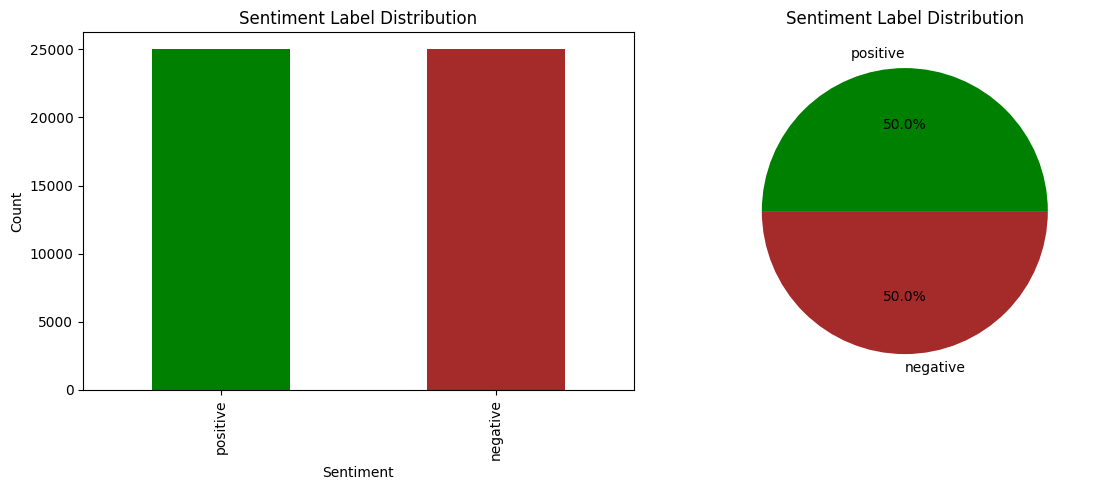


Data Balance Ratio: 1.00


In [34]:
#Sentiment Label Distribution Analysis
print('Sentiment Label Distribution Analysis')
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)
print('\nLabel Distribution Proportion')
print(df['sentiment'].value_counts(normalize=True))


#Visualize Label Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sentiment_counts.plot(kind='bar', ax=axes[0], color=['green','brown'])
axes[0].set_title('Sentiment Label Distribution')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')


#pie chart
axes[1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=['green','brown'])
axes[1].set_title('Sentiment Label Distribution')
plt.tight_layout()
plt.show()


#Check Data Balance
balance_ratio = sentiment_counts.iloc[0] / sentiment_counts.iloc[1]
print(f'\nData Balance Ratio: {balance_ratio:.2f}')



In [39]:
#Text Length Analysis
print('Text Length Analysis')

#Calculate the Character Length and Word Count of Each Comment
df['character_length'] = df['review'].apply(len)
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

print("\nCharacter Length Statistics:")
print(df['character_length'].describe())
print("\nWord Count Statistics:")
print(df['word_count'].describe())

Text Length Analysis

Character Length Statistics:
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: character_length, dtype: float64

Word Count Statistics:
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: word_count, dtype: float64


Length Comparison of Comments with Different Sentiments
          character_length                     word_count                   
                      mean median          std       mean median         std
sentiment                                                                   
negative        1294.06436  973.0   945.892669  229.46456  174.0  164.947795
positive        1324.79768  968.0  1031.492627  232.84932  172.0  177.497046


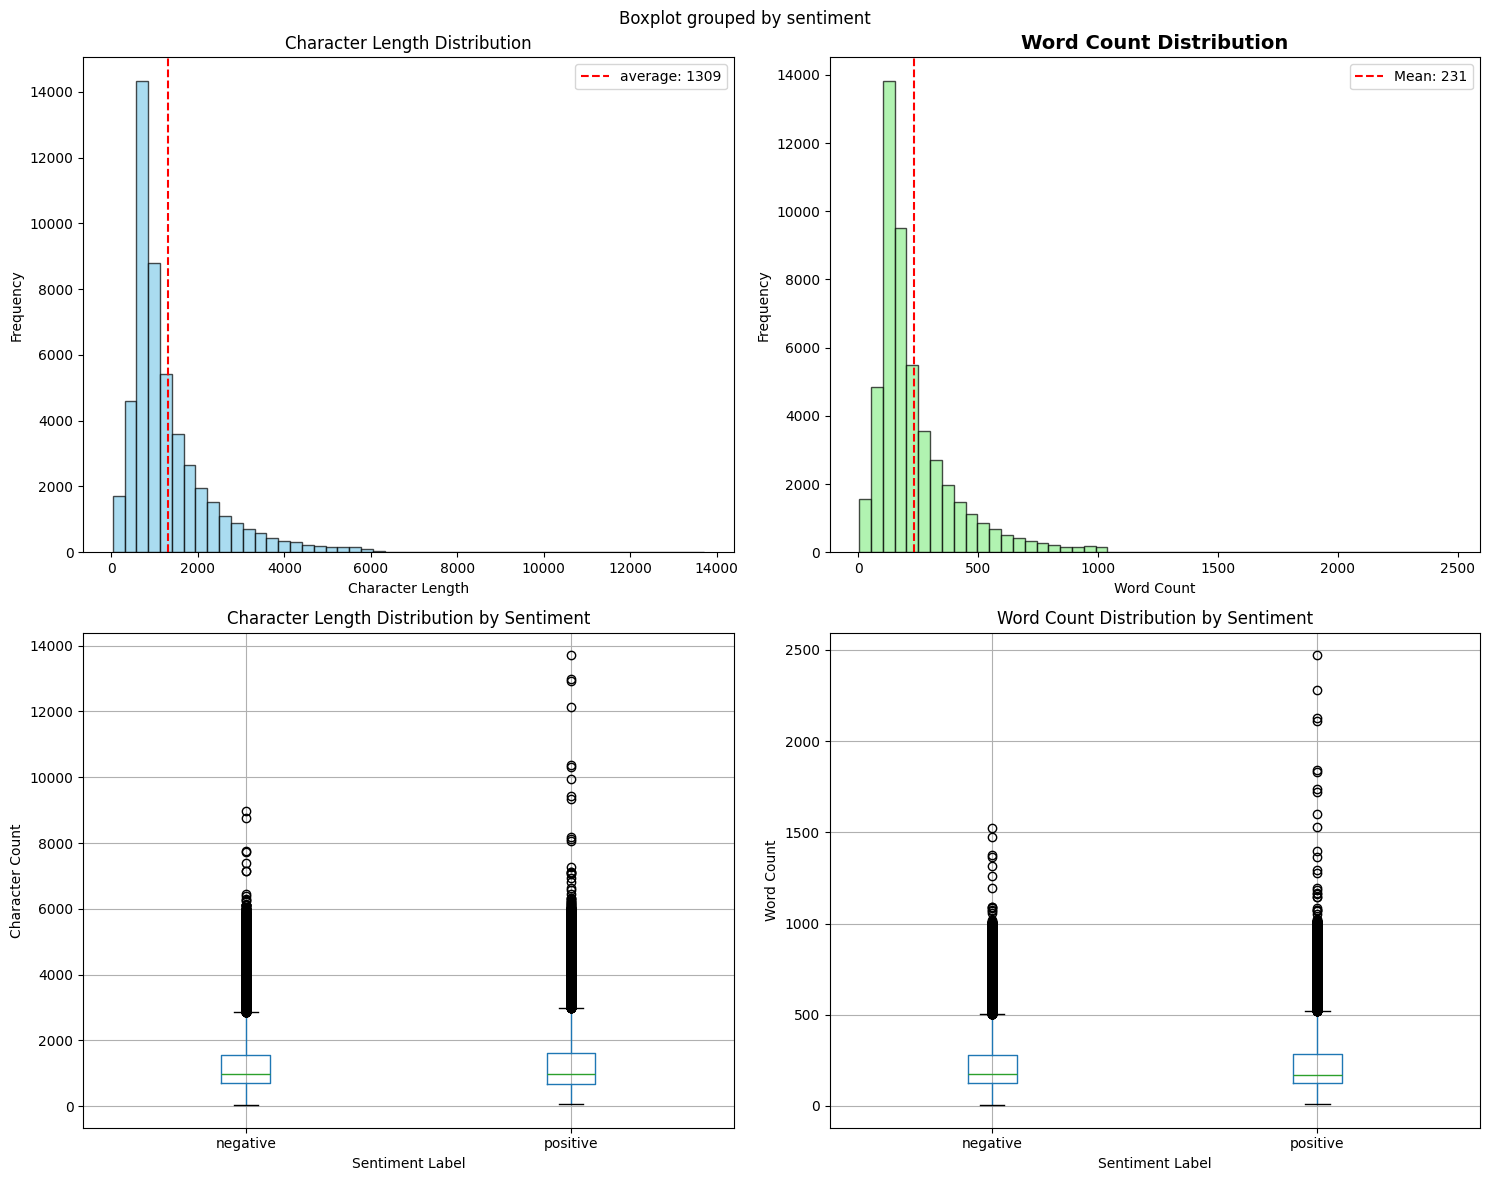


🔍 Outlier Comment Length Analysis:
Shortest Comment Length: 32 characters
Longest Comment Length: 13704 characters

📝 Shortest Comment (32 characters):
Sentiment: negative
Content: Read the book, forget the movie!

📝 Longest Comment (13704 characters):
Sentiment: positive
Content: Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris B...


In [58]:
#Length Comparison of Comments with Different Sentiments
print('Length Comparison of Comments with Different Sentiments')
length_by_sentiment = df.groupby('sentiment')[['character_length', 'word_count']].agg(['mean', 'median', 'std'])
print(length_by_sentiment)

#Visualize Text Length Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

#Character Length Distribution Histogram
axes[0, 0].hist(df['character_length'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Character Length Distribution')
axes[0, 0].set_xlabel('Character Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['character_length'].mean(), color='red', linestyle='--', label=f'average: {df["character_length"].mean():.0f}')
axes[0, 0].legend()

# Word Count Distribution Histogram
axes[0, 1].hist(df['word_count'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["word_count"].mean():.0f}')
axes[0, 1].legend()

# Boxplot of Character Length by Sentiment
df.boxplot(column='character_length', by='sentiment', ax=axes[1, 0])
axes[1, 0].set_title('Character Length Distribution by Sentiment')
axes[1, 0].set_xlabel('Sentiment Label')
axes[1, 0].set_ylabel('Character Count')

# Boxplot of Word Count by Sentiment
df.boxplot(column='word_count', by='sentiment', ax=axes[1, 1])
axes[1, 1].set_title('Word Count Distribution by Sentiment')
axes[1, 1].set_xlabel('Sentiment Label')
axes[1, 1].set_ylabel('Word Count')

plt.tight_layout()
plt.show()

# Identify Outlier Comments by Length
print(f"\n🔍 Outlier Comment Length Analysis:")
print(f"Shortest Comment Length: {df['character_length'].min()} characters")
print(f"Longest Comment Length: {df['character_length'].max()} characters")

# Display Shortest and Longest Comments
shortest_review = df.loc[df['character_length'].idxmin()]
longest_review = df.loc[df['character_length'].idxmax()]

print(f"\n📝 Shortest Comment ({shortest_review['character_length']} characters):")
print(f"Sentiment: {shortest_review['sentiment']}")
print(f"Content: {shortest_review['review']}")

print(f"\n📝 Longest Comment ({longest_review['character_length']} characters):")
print(f"Sentiment: {longest_review['sentiment']}")
print(f"Content: {longest_review['review'][:200]}...")  # Display only the first 200 characters


In [56]:
def clean_text(text):
    """
    Text Cleaning Function

    Parameters:
        text (str): Raw text

    Returns:
        str: Cleaned text
    """
    # Convert to string (to handle NaN values)
    text = str(text)

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Keep only letters, numbers, spaces, and basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?\;]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Convert to lowercase and strip whitespace
    text = text.lower().strip()

    return text

# Test the text cleaning function
print("🧹 Text Cleaning Test:")
sample_text = df['review'].iloc[0]
print(f"Raw Text (first 200 characters): {sample_text[:200]}...")
print(f"Cleaned Text: {clean_text(sample_text)[:200]}...")

# Apply text cleaning to the entire dataset
print("\n🔄 Cleaning all text data...")
start_time = time.time()

df['cleaned_review'] = df['review'].apply(clean_text)

clean_time = time.time() - start_time
print(f"✅ Text cleaning completed! Time taken: {clean_time:.2f} seconds")

# Check the effect of cleaning
print(f"\n📊 Cleaning Effect Comparison:")
print(f"Average length before cleaning: {df['character_length'].mean():.1f} characters")
print(f"Average length after cleaning: {df['cleaned_review'].apply(len).mean():.1f} characters")

# Display examples of text before and after cleaning
print(f"\n🔍 Before and After Cleaning Examples:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original: {df['review'].iloc[i][:150]}...")
    print(f"Cleaned: {df['cleaned_review'].iloc[i][:150]}...")

🧹 Text Cleaning Test:
Raw Text (first 200 characters): One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...
Cleaned Text: one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked. they are right, as this is exactly what happened with me.the first thing that struck me about oz was its...

🔄 Cleaning all text data...
✅ Text cleaning completed! Time taken: 7.65 seconds

📊 Cleaning Effect Comparison:
Average length before cleaning: 1309.4 characters
Average length after cleaning: 1269.4 characters

🔍 Before and After Cleaning Examples:

Example 1:
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with...
Cleaned: one of the other reviewers has mentioned that after watching just 1 oz episode youll be 

🔢 Starting text tokenization and encoding...
Building vocabulary...
✅ Vocabulary built successfully!
Total vocabulary size: 150129
Used vocabulary size: 10000
Vocabulary size (including padding): 150130

📚 Top 20 most common words:
 1: <OOV>
 2: the
 3: and
 4: a
 5: of
 6: to
 7: is
 8: in
 9: it
10: i
11: this
12: that
13: was
14: as
15: with
16: for
17: movie
18: but
19: film
20: on

🔄 Converting text to numerical sequences...
Conversion completed! Number of sequences: 50000

🔍 Text conversion example:
Original text: one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked. they...
Numerical sequence: [28, 5, 2, 77, 1963, 45, 1063, 12, 101, 145, 40, 421, 3095, 389, 466, 26, 3145, 34, 23, 201]...

📊 Sequence length statistics:
Average length: 228.5
Median length: 171.0
Shortest length: 6
Longest length: 2451
Set maximum length: 100


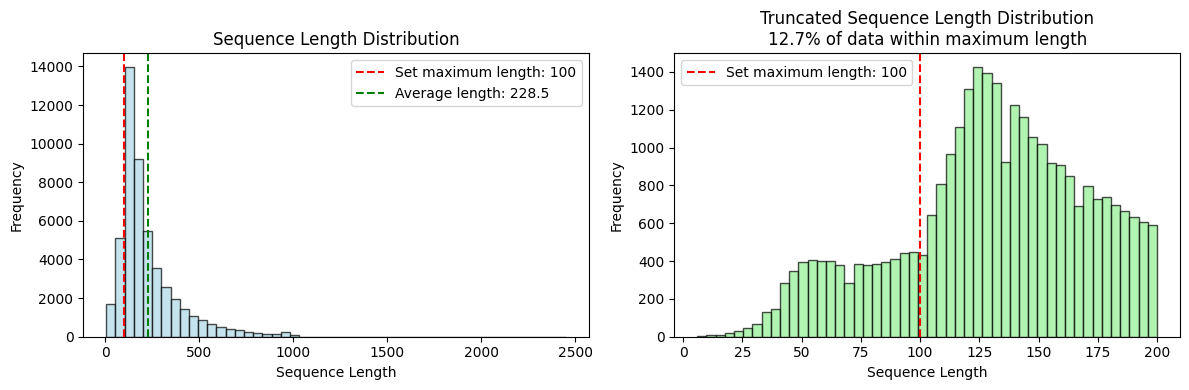


📈 12.7% of sequences are within the set maximum length 100


In [57]:
# Set tokenizer parameters
MAX_WORDS = 10000        # Maximum vocabulary size
MAX_LENGTH = 100         # Maximum sequence length
OOV_TOKEN = "<OOV>"      # Out-of-vocabulary token

print("🔢 Starting text tokenization and encoding...")

# Create tokenizer
tokenizer = Tokenizer(
    num_words=MAX_WORDS,     # Keep only the 10,000 most common words
    oov_token=OOV_TOKEN,     # Set out-of-vocabulary token
    lower=True               # Convert to lowercase
)

# Fit tokenizer on training data
print("Building vocabulary...")
tokenizer.fit_on_texts(df['cleaned_review'])

# Get vocabulary information
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # +1 for padding token

print(f"✅ Vocabulary built successfully!")
print(f"Total vocabulary size: {len(word_index)}")
print(f"Used vocabulary size: {min(MAX_WORDS, len(word_index))}")
print(f"Vocabulary size (including padding): {vocab_size}")

# Display the most common words
print(f"\n📚 Top 20 most common words:")
most_common_words = list(word_index.items())[:20]
for word, index in most_common_words:
    print(f"{index:2d}: {word}")

# Convert text to numerical sequences
print(f"\n🔄 Converting text to numerical sequences...")
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

print(f"Conversion completed! Number of sequences: {len(sequences)}")

# Display conversion example
print(f"\n🔍 Text conversion example:")
sample_idx = 0
print(f"Original text: {df['cleaned_review'].iloc[sample_idx][:100]}...")
print(f"Numerical sequence: {sequences[sample_idx][:20]}...")  # Show only first 20 numbers

# Analyze sequence length distribution
sequence_lengths = [len(seq) for seq in sequences]
print(f"\n📊 Sequence length statistics:")
print(f"Average length: {np.mean(sequence_lengths):.1f}")
print(f"Median length: {np.median(sequence_lengths):.1f}")
print(f"Shortest length: {min(sequence_lengths)}")
print(f"Longest length: {max(sequence_lengths)}")
print(f"Set maximum length: {MAX_LENGTH}")

# Visualize sequence length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(sequence_lengths, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
plt.axvline(MAX_LENGTH, color='red', linestyle='--', label=f'Set maximum length: {MAX_LENGTH}')
plt.axvline(np.mean(sequence_lengths), color='green', linestyle='--', label=f'Average length: {np.mean(sequence_lengths):.1f}')
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
# Show proportion of sequences within MAX_LENGTH
within_max_length = sum(1 for length in sequence_lengths if length <= MAX_LENGTH)
percentage = within_max_length / len(sequence_lengths) * 100
plt.hist([l for l in sequence_lengths if l <= MAX_LENGTH*2], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(MAX_LENGTH, color='red', linestyle='--', label=f'Set maximum length: {MAX_LENGTH}')
plt.title(f'Truncated Sequence Length Distribution\n{percentage:.1f}% of data within maximum length')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n📈 {percentage:.1f}% of sequences are within the set maximum length {MAX_LENGTH}")



In [59]:
# Sequence padding
print("🔧 Sequence padding processing...")
X = pad_sequences(
    sequences,
    maxlen=MAX_LENGTH,    # Maximum length
    padding='post',       # Pad at the end
    truncating='post'     # Truncate from the end
)

print(f"✅ Sequence padding completed!")
print(f"Padded data shape: {X.shape}")
print(f"Data type: {X.dtype}")

# Label encoding
print(f"\n🏷️ Label encoding...")
label_map = {'negative': 0, 'positive': 1}
y = df['sentiment'].map(label_map).values

print(f"Label encoding completed!")
print(f"Label shape: {y.shape}")
print(f"Label distribution: {np.bincount(y)}")

# Display padding example
print(f"\n🔍 Padding example:")
sample_idx = 0
print(f"Original sequence length: {len(sequences[sample_idx])}")
print(f"Original sequence: {sequences[sample_idx][:10]}...")
print(f"Padded sequence: {X[sample_idx][:15]}...")
print(f"Sequence end: ...{X[sample_idx][-15:]}")

🔧 Sequence padding processing...
✅ Sequence padding completed!
Padded data shape: (50000, 100)
Data type: int32

🏷️ Label encoding...
Label encoding completed!
Label shape: (50000,)
Label distribution: [25000 25000]

🔍 Padding example:
Original sequence length: 308
Original sequence: [28, 5, 2, 77, 1963, 45, 1063, 12, 101, 145]...
Padded sequence: [  28    5    2   77 1963   45 1063   12  101  145   40  421 3095  389
  466]...
Sequence end: ...[   2  666    9    7  475 3095   14   12    7    2    1  346    6    2
    1]


📊 Dataset splitting...
✅ Dataset splitting completed!
Training set: (30000, 100) - 30000 samples
Validation set: (10000, 100) - 10000 samples
Test set: (10000, 100) - 10000 samples

📈 Label distribution in each dataset:
Training set - Negative: 15000, Positive: 15000
Validation set - Negative: 5000, Positive: 5000
Test set - Negative: 5000, Positive: 5000


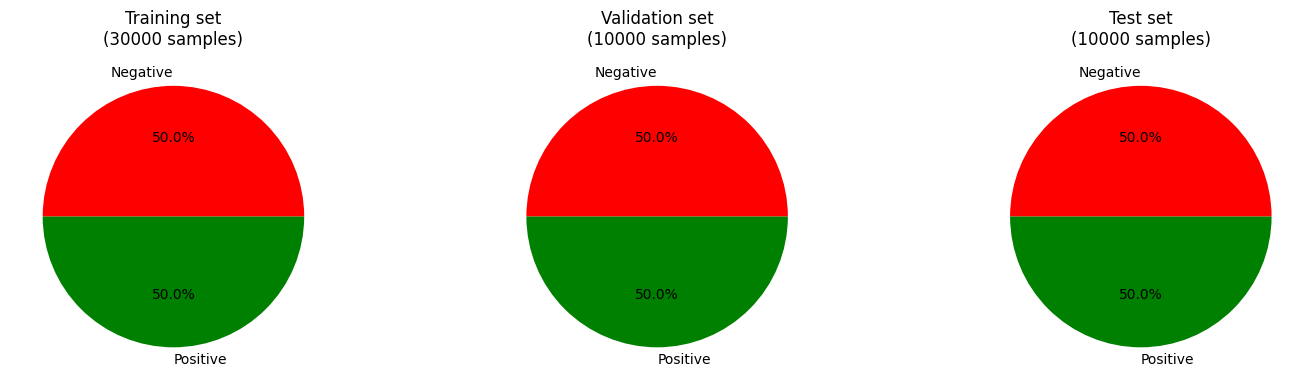

In [60]:
# Dataset splitting
print("📊 Dataset splitting...")

# First split into training+validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% as test set
    random_state=SEED,
    stratify=y            # Maintain label distribution
)

# Further split training+validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,       # 25% of 80% = 20% as validation set
    random_state=SEED,
    stratify=y_temp
)

print(f"✅ Dataset splitting completed!")
print(f"Training set: {X_train.shape} - {len(y_train)} samples")
print(f"Validation set: {X_val.shape} - {len(y_val)} samples")
print(f"Test set: {X_test.shape} - {len(y_test)} samples")

# Check label distribution
print(f"\n📈 Label distribution in each dataset:")
print(f"Training set - Negative: {sum(y_train == 0)}, Positive: {sum(y_train == 1)}")
print(f"Validation set - Negative: {sum(y_val == 0)}, Positive: {sum(y_val == 1)}")
print(f"Test set - Negative: {sum(y_test == 0)}, Positive: {sum(y_test == 1)}")

# Visualize dataset splitting results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
datasets = [('Training set', y_train), ('Validation set', y_val), ('Test set', y_test)]

for i, (name, labels) in enumerate(datasets):
    counts = np.bincount(labels)
    axes[i].pie(counts, labels=['Negative', 'Positive'], autopct='%1.1f%%',
               colors=['red', 'green'])
    axes[i].set_title(f'{name}\n({len(labels)} samples)')

plt.tight_layout()
plt.show()

In [61]:
# Model parameter settings
EMBEDDING_DIM = 128      # Word embedding dimension
LSTM_UNITS = 64          # Number of LSTM units
DENSE_UNITS = 32         # Number of dense layer units
DROPOUT_RATE = 0.3       # Dropout rate

#[64, 32]

print("🏗️ Building LSTM model...")

def create_lstm_model(vocab_size, embedding_dim, lstm_units, dense_units, max_length, dropout_rate):
    """
    Create LSTM sentiment classification model

    Parameters:
        vocab_size: Vocabulary size
        embedding_dim: Word embedding dimension
        lstm_units: Number of LSTM units
        dense_units: Number of dense layer units
        max_length: Maximum sequence length
        dropout_rate: Dropout rate

    Returns:
        model: Compiled Keras model
    """

    model = Sequential([
        # Embedding layer: Convert word IDs to dense vectors
        Embedding(
            input_dim=vocab_size,      # Vocabulary size
            output_dim=embedding_dim,   # Embedding vector dimension
            input_length=max_length,    # Input sequence length
            name='embedding'
        ),

        # Dropout layer: Prevent overfitting
        Dropout(dropout_rate, name='embedding_dropout'),

        # LSTM layer: Process sequential data
        LSTM(
            units=lstm_units,           # Number of LSTM units
            dropout=dropout_rate,       # Dropout for LSTM inputs
            recurrent_dropout=dropout_rate,  # Dropout for recurrent connections
            return_sequences=False,     # Return only the last time step's output
            name='lstm'
        ),

        # Dense layer: Perform feature transformation
        Dense(
            units=dense_units,
            activation='relu',
            name='dense'
        ),

        # Dropout layer
        Dropout(dropout_rate, name='dense_dropout'),

        # Output layer: Binary classification
        Dense(
            units=1,
            activation='sigmoid',       # Sigmoid activation for 0-1 probability output
            name='output'
        )
    ])

    return model

# Create model
model = create_lstm_model(
    vocab_size=min(MAX_WORDS, len(word_index)) + 1,
    embedding_dim=EMBEDDING_DIM,
    lstm_units=LSTM_UNITS,
    dense_units=DENSE_UNITS,
    max_length=MAX_LENGTH,
    dropout_rate=DROPOUT_RATE
)

# Display model structure
print("✅ Model creation completed!")
print("\n📋 Model structure:")
model.summary()

# Visualize model architecture
try:
    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)
    print("\n🖼️ Model architecture diagram saved as lstm_model.png")
except Exception as e:
    print(f"\n⚠️ Unable to generate model architecture diagram: {e}")

🏗️ Building LSTM model...
✅ Model creation completed!

📋 Model structure:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout (Dropout)     │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_dropout (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


⚠️ Unable to generate model architecture diagram: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.


In [62]:
# Compile model
print("⚙️ Compiling model...")

model.compile(
    optimizer='adam',              # Adam optimizer: adaptive learning rate
    loss='binary_crossentropy',   # Binary cross-entropy loss
    metrics=['accuracy']          # Monitor accuracy
)

print("✅ Model compilation completed!")

# Display compilation parameters
print(f"\n🔧 Compilation parameters:")
print(f"Optimizer: Adam")
print(f"Loss function: binary_crossentropy")
print(f"Evaluation metric: accuracy")

# Calculate model parameter count
# Build the model before calling count_params
model.build(input_shape=(None, MAX_LENGTH))
total_params = model.count_params()
print(f"\n📊 Model parameter statistics:")
print(f"Total parameter count: {total_params:,}")

# Layer-wise parameter statistics
for layer in model.layers:
    layer_params = layer.count_params()
    print(f"{layer.name}: {layer_params:,} parameters")

⚙️ Compiling model...
✅ Model compilation completed!

🔧 Compilation parameters:
Optimizer: Adam
Loss function: binary_crossentropy
Evaluation metric: accuracy

📊 Model parameter statistics:
Total parameter count: 1,331,649
embedding: 1,280,128 parameters
embedding_dropout: 0 parameters
lstm: 49,408 parameters
dense: 2,080 parameters
dense_dropout: 0 parameters
output: 33 parameters


In [63]:
# Training parameters
BATCH_SIZE = 32          # Batch size
EPOCHS = 10              # Number of training epochs
VALIDATION_SPLIT = None  # Use separate validation set

print("🎯 Setting up training configuration...")

# Set up callbacks
callbacks = [
    # Early stopping: Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',      # Monitor validation loss
        patience=3,              # Allow 3 epochs without improvement
        restore_best_weights=True,  # Restore best weights
        verbose=1
    ),

    # Model checkpoint: Save the best model
    ModelCheckpoint(
        filepath='best_lstm_model.h5',
        monitor='val_accuracy',  # Monitor validation accuracy
        save_best_only=True,     # Save only the best model
        save_weights_only=False,
        verbose=1
    ),

    # Learning rate scheduling: Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,              # Reduce learning rate by half
        patience=2,              # Adjust after 2 epochs without improvement # warm-up
        min_lr=1e-6,             # Minimum learning rate
        verbose=1
    )
]

print(f"✅ Training configuration completed!")
print(f"\n🔧 Training parameters:")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of epochs: {EPOCHS}")
print(f"Early stopping patience: 3")
print(f"Learning rate scheduling: Enabled")
print(f"Model checkpoint: Enabled")

🎯 Setting up training configuration...
✅ Training configuration completed!

🔧 Training parameters:
Batch size: 32
Number of epochs: 10
Early stopping patience: 3
Learning rate scheduling: Enabled
Model checkpoint: Enabled


In [64]:
import time

# Start training
print("🚀 Starting LSTM model training...")
print(f"Training data: {X_train.shape}")
print(f"Validation data: {X_val.shape}")
print("=" * 50)

start_time = time.time()

# Train the model
history = model.fit(
    X_train, y_train,                    # Training data
    batch_size=BATCH_SIZE,               # Batch size
    epochs=EPOCHS,                       # Number of epochs
    validation_data=(X_val, y_val),      # Validation data
    callbacks=callbacks,                 # Callbacks
    verbose=1                            # Display training progress
)

training_time = time.time() - start_time
print(f"\n✅ Training completed! Time taken: {training_time:.2f} seconds ({training_time/60:.1f} minutes)")

# Training history summary
print(f"\n📊 Training history summary:")
print(f"Number of epochs trained: {len(history.history['loss'])}")

# Note: Whether 'accuracy'/'val_accuracy' is included depends on model.compile configuration
if "val_accuracy" in history.history:
    print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
if "val_loss" in history.history:
    print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
if "accuracy" in history.history:
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")

🚀 Starting LSTM model training...
Training data: (30000, 100)
Validation data: (10000, 100)
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.5991 - loss: 0.6551
Epoch 1: val_accuracy improved from -inf to 0.63890, saving model to best_lstm_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 322s 336ms/step - accuracy: 0.5992 - loss: 0.6551 - val_accuracy: 0.6389 - val_loss: 0.6355 - learning_rate: 0.0010
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6559 - loss: 0.6080
Epoch 2: val_accuracy improved from 0.63890 to 0.82500, saving model to best_lstm_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 313s 330ms/step - accuracy: 0.6559 - loss: 0.6079 - val_accuracy: 0.8250 - val_loss: 0.3955 - learning_rate: 0.0010
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8424 - loss: 0.3748
Epoch 3: val_accuracy improved from 0.82500 to 0.83370, saving model to best_lstm_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 327s 335ms/step - accuracy: 0.8424 - loss: 0.3748 - val_accuracy: 0.8337 - val_loss: 0.3751 - learning_rate: 0.0010
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.8857 - loss: 0.2979
Epoch 4: val_accuracy did not improve from 0.83370
938/938 ━━━━━━━━━━━━━━━━━━━━ 317s 330ms/step - accuracy: 0.8857 - loss: 0.2978 - val_accuracy: 0.8327 - val_loss: 0.3915 - learning_rate: 0.0010
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9105 - loss: 0.2470
Epoch 5: val_accuracy did not improve from 0.83370

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
938/938 ━━━━━━━━━━━━━━━━━━━━ 325s 334ms/step - accuracy: 0.9105 - loss: 0.2470 - val_accuracy: 0.8319 - val_loss: 0.4248 - learning_rate: 0.0010
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9314 - loss: 0.1977
Epoch 6: val_accuracy did not improve from 0.83370
938/938 ━━━━━━━━━━━━━━━━━━━━ 322s 333ms/step - accuracy: 0.9314 - loss:

📈 Visualizing training process...


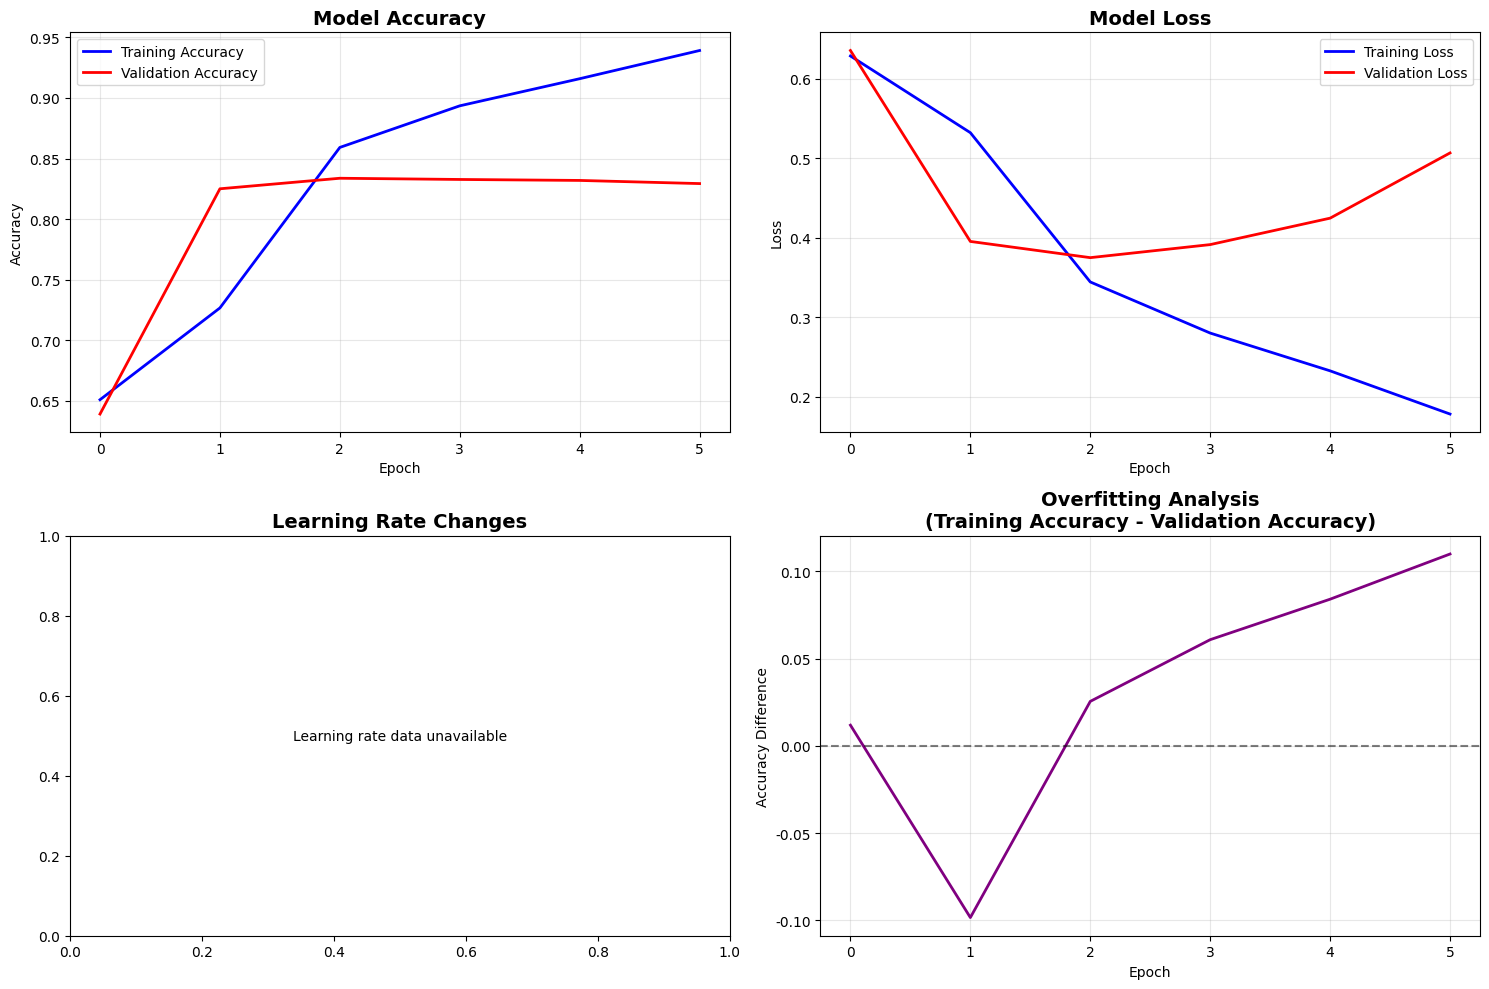


🔍 Training results analysis:
Final training accuracy: 0.9392
Final validation accuracy: 0.8293
Best validation accuracy: 0.8337
Training-validation accuracy difference: 0.1099
⚠️ Potential overfitting detected, consider increasing regularization
👍 Good model performance


In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize training history
print("📈 Visualizing training process...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy curve
if "accuracy" in history.history and "val_accuracy" in history.history:
    axes[0, 0].plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
else:
    axes[0, 0].text(0.5, 0.5, 'Accuracy data unavailable', ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')

# Loss curve
axes[0, 1].plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
if "val_loss" in history.history:
    axes[0, 1].plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate curve (if available)
if 'lr' in history.history:
    axes[1, 0].plot(history.history['lr'], 'g-', linewidth=2)
    axes[1, 0].set_title('Learning Rate Changes', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Learning rate data unavailable', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Learning Rate Changes', fontsize=14, fontweight='bold')

# Training vs Validation accuracy difference
if "accuracy" in history.history and "val_accuracy" in history.history:
    train_val_diff = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
    axes[1, 1].plot(train_val_diff, 'purple', linewidth=2)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('Overfitting Analysis\n(Training Accuracy - Validation Accuracy)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy Difference')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Accuracy difference unavailable', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Overfitting Analysis', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Analyze training results
print("\n🔍 Training results analysis:")
if "accuracy" in history.history and "val_accuracy" in history.history:
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    accuracy_gap = final_train_acc - final_val_acc

    print(f"Final training accuracy: {final_train_acc:.4f}")
    print(f"Final validation accuracy: {final_val_acc:.4f}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print(f"Training-validation accuracy difference: {accuracy_gap:.4f}")

    if accuracy_gap > 0.05:
        print("⚠️ Potential overfitting detected, consider increasing regularization")
    elif accuracy_gap < -0.02:
        print("📈 Potential underfitting detected, consider increasing model complexity")
    else:
        print("✅ Model fits well")

    if best_val_acc > 0.85:
        print("🎉 Excellent model performance!")
    elif best_val_acc > 0.75:
        print("👍 Good model performance")
    else:
        print("📝 Model performance needs improvement")
else:
    print("ℹ️ No accuracy metrics available, possibly using a regression task or metrics=['accuracy'] not set")

In [66]:
# Load the best model (if saved)
if os.path.exists('best_lstm_model.h5'):
    print("📦 Loading the best saved model...")
    best_model = tf.keras.models.load_model('best_lstm_model.h5')
    print("✅ Model loaded successfully!")
else:
    print("📝 Using the currently trained model...")
    best_model = model

# Make predictions on the test set
print("\n🔮 Making predictions on the test set...")
test_predictions = best_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
test_predictions_binary = (test_predictions > 0.5).astype(int).flatten()

# Calculate test set accuracy
test_accuracy = accuracy_score(y_test, test_predictions_binary)
test_auc = roc_auc_score(y_test, test_predictions)

print(f"\n📊 Test set performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AUC score: {test_auc:.4f}")

# Detailed classification report
print(f"\n📋 Detailed classification report:")
class_names = ['Negative', 'Positive']
report = classification_report(y_test, test_predictions_binary,
                             target_names=class_names, digits=4)
print(report)

📦 Loading the best saved model...


✅ Model loaded successfully!

🔮 Making predictions on the test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step

📊 Test set performance:
Accuracy: 0.8378
AUC score: 0.9188

📋 Detailed classification report:
              precision    recall  f1-score   support

    Negative     0.8389    0.8362    0.8375      5000
    Positive     0.8367    0.8394    0.8381      5000

    accuracy                         0.8378     10000
   macro avg     0.8378    0.8378    0.8378     10000
weighted avg     0.8378    0.8378    0.8378     10000



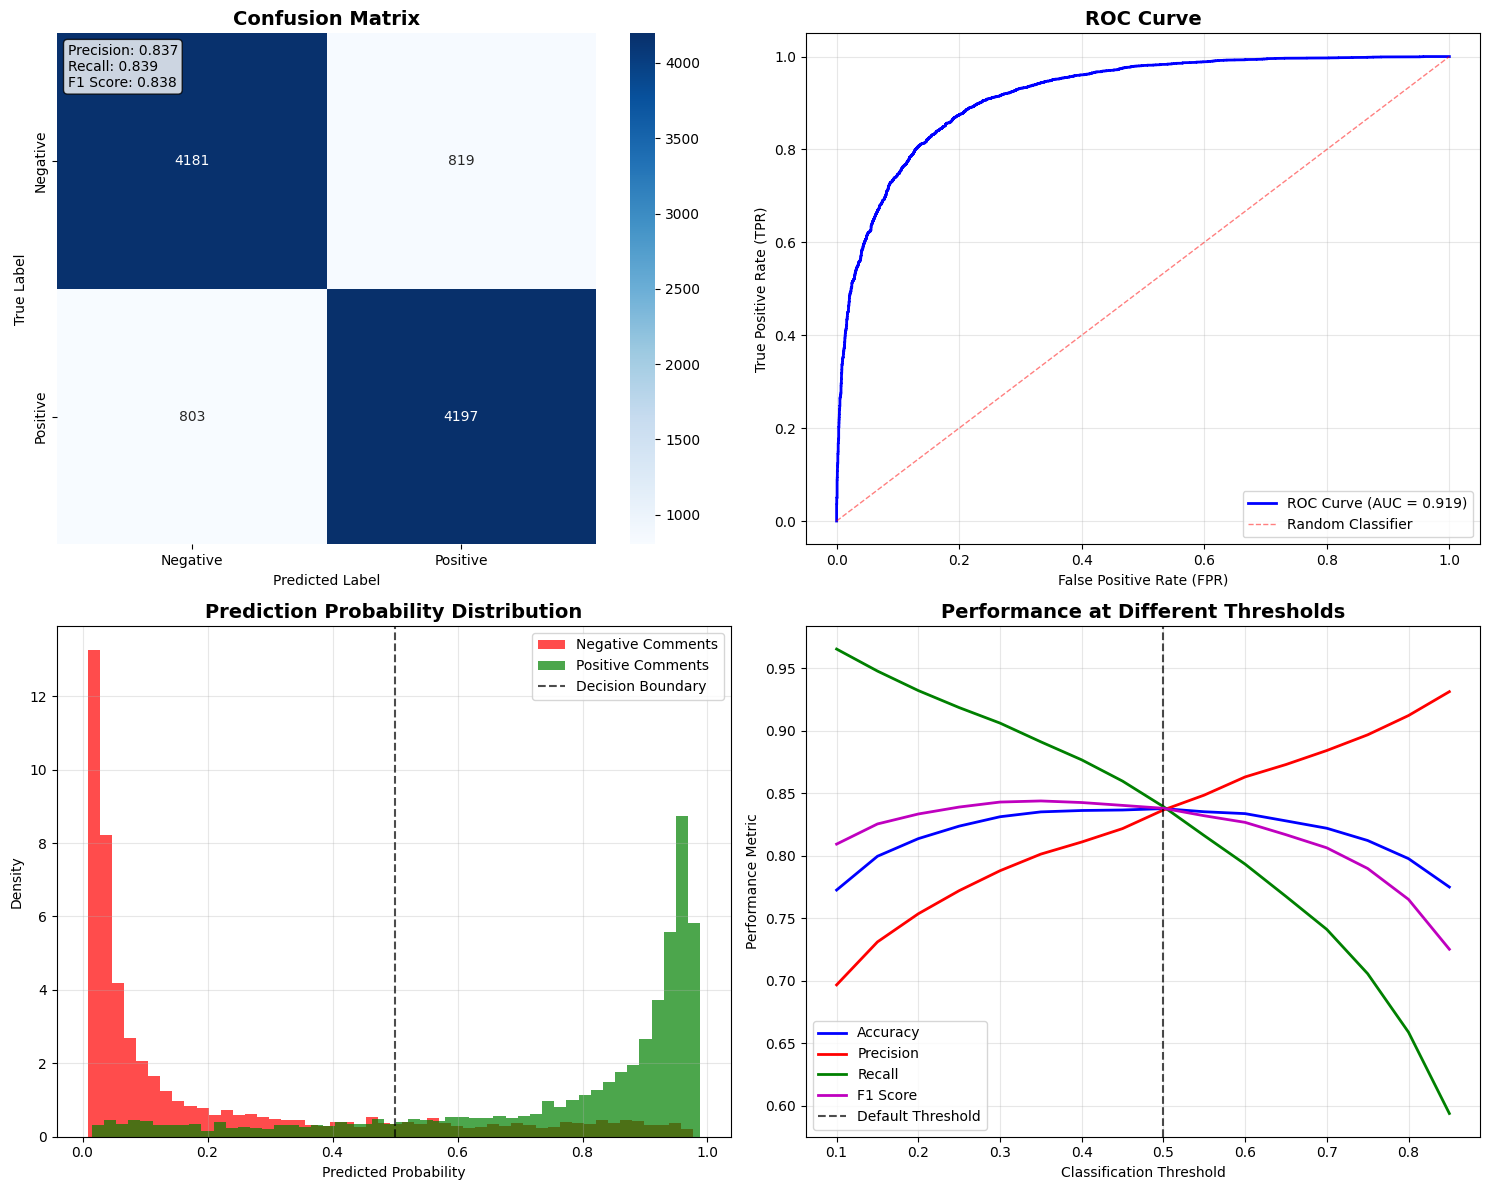


🎯 Optimal classification threshold: 0.35 (F1 Score: 0.8439)


In [67]:
# Visualize evaluation results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion matrix
cm = confusion_matrix(y_test, test_predictions_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names, ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_ylabel('True Label')

# Add confusion matrix statistics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

stats_text = f'Precision: {precision:.3f}\nRecall: {recall:.3f}\nF1 Score: {f1_score:.3f}'
axes[0, 0].text(0.02, 0.98, stats_text, transform=axes[0, 0].transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
axes[0, 1].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {test_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'r--', linewidth=1, alpha=0.5, label='Random Classifier')
axes[0, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('False Positive Rate (FPR)')
axes[0, 1].set_ylabel('True Positive Rate (TPR)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Prediction probability distribution
axes[1, 0].hist(test_predictions[y_test == 0], bins=50, alpha=0.7,
               color='red', label='Negative Comments', density=True)
axes[1, 0].hist(test_predictions[y_test == 1], bins=50, alpha=0.7,
               color='green', label='Positive Comments', density=True)
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Decision Boundary')
axes[1, 0].set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Probability')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Performance at different thresholds
threshold_range = np.arange(0.1, 0.9, 0.05)
accuracies = []
precisions = []
recalls = []
f1_scores = []

from sklearn.metrics import precision_score, recall_score, f1_score

for threshold in threshold_range:
    pred_binary = (test_predictions > threshold).astype(int).flatten()
    acc = accuracy_score(y_test, pred_binary)

    if len(np.unique(pred_binary)) > 1:  # Avoid cases with only one class
        prec = precision_score(y_test, pred_binary, zero_division=0)
        rec = recall_score(y_test, pred_binary, zero_division=0)
        f1 = f1_score(y_test, pred_binary, zero_division=0)
    else:
        prec = rec = f1 = 0

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

axes[1, 1].plot(threshold_range, accuracies, 'b-', label='Accuracy', linewidth=2)
axes[1, 1].plot(threshold_range, precisions, 'r-', label='Precision', linewidth=2)
axes[1, 1].plot(threshold_range, recalls, 'g-', label='Recall', linewidth=2)
axes[1, 1].plot(threshold_range, f1_scores, 'm-', label='F1 Score', linewidth=2)
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Default Threshold')
axes[1, 1].set_title('Performance at Different Thresholds', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Classification Threshold')
axes[1, 1].set_ylabel('Performance Metric')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find the optimal threshold
best_threshold_idx = np.argmax(f1_scores)
best_threshold = threshold_range[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"\n🎯 Optimal classification threshold: {best_threshold:.2f} (F1 Score: {best_f1:.4f})")

🔍 Error analysis...
Number of misclassifications: 1622 / 10000 (16.2%)

False positives (predicted positive, actual negative): 819
False negatives (predicted negative, actual positive): 803

📝 False Positive Samples (Most Confident Misclassifications):

Example 1:
Prediction probability: 0.977
Predicted label: Positive
Actual label: Negative
Sequence length: 100
------------------------------

Example 2:
Prediction probability: 0.975
Predicted label: Positive
Actual label: Negative
Sequence length: 100
------------------------------

Example 3:
Prediction probability: 0.975
Predicted label: Positive
Actual label: Negative
Sequence length: 100
------------------------------

📝 False Negative Samples (Most Confident Misclassifications):

Example 1:
Prediction probability: 0.015
Predicted label: Negative
Actual label: Positive
Sequence length: 100
------------------------------

Example 2:
Prediction probability: 0.015
Predicted label: Negative
Actual label: Positive
Sequence length: 100


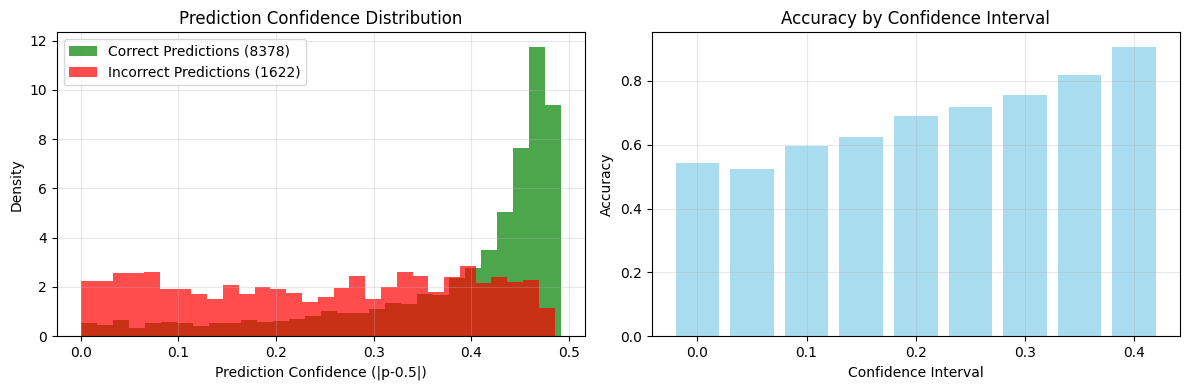

In [68]:
# Error analysis
print("🔍 Error analysis...")

# Identify misclassified samples
wrong_predictions = np.where(test_predictions_binary != y_test)[0]
print(f"Number of misclassifications: {len(wrong_predictions)} / {len(y_test)} ({len(wrong_predictions)/len(y_test)*100:.1f}%)")

# Analyze misclassified samples
false_positives = np.where((test_predictions_binary == 1) & (y_test == 0))[0]  # False positives
false_negatives = np.where((test_predictions_binary == 0) & (y_test == 1))[0]  # False negatives

print(f"\nFalse positives (predicted positive, actual negative): {len(false_positives)}")
print(f"False negatives (predicted negative, actual positive): {len(false_negatives)}")

# Display misclassified examples
def show_misclassified_examples(indices, title, max_examples=3):
    print(f"\n{title}:")
    print("="*50)

    # Sort by prediction confidence
    if len(indices) > 0:
        confidences = np.abs(test_predictions[indices] - 0.5).flatten()
        sorted_indices = indices[np.argsort(-confidences)][:max_examples]

        for i, idx in enumerate(sorted_indices):
            actual_text_idx = idx  # Map back to original text index
            print(f"\nExample {i+1}:")
            print(f"Prediction probability: {test_predictions[idx][0]:.3f}")
            print(f"Predicted label: {'Positive' if test_predictions_binary[idx] == 1 else 'Negative'}")
            print(f"Actual label: {'Positive' if y_test[idx] == 1 else 'Negative'}")
            # Note: Cannot directly display original text because test set indices may not correspond to original data indices
            print(f"Sequence length: {np.sum(X_test[idx] != 0)}")
            print("-" * 30)

show_misclassified_examples(false_positives, "📝 False Positive Samples (Most Confident Misclassifications)")
show_misclassified_examples(false_negatives, "📝 False Negative Samples (Most Confident Misclassifications)")

# Prediction confidence analysis
print(f"\n📊 Prediction confidence analysis:")
confident_correct = np.where((np.abs(test_predictions - 0.5) > 0.3) &
                           (test_predictions_binary == y_test))[0]
confident_wrong = np.where((np.abs(test_predictions - 0.5) > 0.3) &
                         (test_predictions_binary != y_test))[0]

print(f"High-confidence correct predictions: {len(confident_correct)} ({len(confident_correct)/len(y_test)*100:.1f}%)")
print(f"High-confidence incorrect predictions: {len(confident_wrong)} ({len(confident_wrong)/len(y_test)*100:.1f}%)")

# Visualize confidence distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
correct_confidences = np.abs(test_predictions[test_predictions_binary == y_test] - 0.5)
wrong_confidences = np.abs(test_predictions[test_predictions_binary != y_test] - 0.5)

plt.hist(correct_confidences, bins=30, alpha=0.7, color='green',
         label=f'Correct Predictions ({len(correct_confidences)})', density=True)
plt.hist(wrong_confidences, bins=30, alpha=0.7, color='red',
         label=f'Incorrect Predictions ({len(wrong_confidences)})', density=True)
plt.xlabel('Prediction Confidence (|p-0.5|)')
plt.ylabel('Density')
plt.title('Prediction Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Accuracy by confidence interval
confidence_bins = np.arange(0, 0.5, 0.05)
accuracy_by_confidence = []
for i in range(len(confidence_bins)-1):
    mask = (np.abs(test_predictions - 0.5).flatten() >= confidence_bins[i]) & \
           (np.abs(test_predictions - 0.5).flatten() < confidence_bins[i+1])
    if np.sum(mask) > 0:
        acc = accuracy_score(y_test[mask], test_predictions_binary[mask])
    else:
        acc = 0
    accuracy_by_confidence.append(acc)

plt.bar(confidence_bins[:-1], accuracy_by_confidence, width=0.04, alpha=0.7, color='skyblue')
plt.xlabel('Confidence Interval')
plt.ylabel('Accuracy')
plt.title('Accuracy by Confidence Interval')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()